In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../Kaggle_dataset/ACWV4.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,56.889999,57.200001,56.230000,56.369999,47.750607,30700
1,1/3/2013,56.560001,56.639999,56.470001,56.500000,47.860737,30000
2,1/4/2013,56.490002,56.740002,56.490002,56.689999,48.021675,45700
3,1/7/2013,56.619999,56.619999,56.250000,56.349998,47.733665,49700
4,1/8/2013,56.380001,56.439999,56.250000,56.439999,47.809914,19200


In [3]:
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1)) 
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]
                
                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\Magda\anaconda3\lib\site-packages\ipykernel_launcher.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


epoch: 10, total rewards: 3449.739998.3, cost: -4902.155762, total money: 385.599976
epoch: 20, total rewards: 3050.650002.3, cost: -8987.391602, total money: 825.080002
epoch: 30, total rewards: 966.650021.3, cost: -27455.316406, total money: 7584.780010
epoch: 40, total rewards: 82.740028.3, cost: -33243.558594, total money: 10082.740028
epoch: 50, total rewards: 451.100025.3, cost: -31175.343750, total money: 8463.720020
epoch: 60, total rewards: 154.930023.3, cost: -32854.007812, total money: 9393.710022
epoch: 70, total rewards: 402.920025.3, cost: -31099.259766, total money: 7381.890011
epoch: 80, total rewards: 333.520042.3, cost: -31610.511719, total money: 8816.160034
epoch: 90, total rewards: 364.339966.3, cost: -31554.376953, total money: 7627.789955
epoch: 100, total rewards: 397.339973.3, cost: -31239.167969, total money: 8122.889969
epoch: 110, total rewards: 398.859966.3, cost: -31699.171875, total money: 7467.839962
epoch: 120, total rewards: 426.879989.3, cost: -31341.

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 4: buy 1 unit at price 56.439999, total balance 9943.560001
day 5: buy 1 unit at price 56.549999, total balance 9887.010002
day 6, sell 1 unit at price 56.849998, investment 0.726435 %, total balance 9943.860001,
day 8: buy 1 unit at price 56.889999, total balance 9886.970001
day 10: buy 1 unit at price 57.020000, total balance 9829.950001
day 11, sell 1 unit at price 57.320000, investment 1.361628 %, total balance 9887.270000,
day 12: buy 1 unit at price 57.380001, total balance 9829.889999
day 13, sell 1 unit at price 57.400002, investment 0.896471 %, total balance 9887.290001,
day 14: buy 1 unit at price 57.520000, total balance 9829.770000
day 15, sell 1 unit at price 57.459999, investment 0.771657 %, total balance 9887.230000,
day 17: buy 1 unit at price 57.630001, total balance 9829.599998
day 20: buy 1 unit at price 58.009998, total balance 9771.590000
day 21: buy 1 unit at price 58.189999, total balance 9713.400002
day 24, sell 1 unit at price 58.180000, investment 1.394213

day 167, sell 1 unit at price 59.840000, investment -0.366302 %, total balance 9144.220001,
day 168, sell 1 unit at price 59.880001, investment -1.188115 %, total balance 9204.100002,
day 170, sell 1 unit at price 60.169998, investment -3.092289 %, total balance 9264.270000,
day 171: buy 1 unit at price 60.360001, total balance 9203.910000
day 172, sell 1 unit at price 61.009998, investment -1.501454 %, total balance 9264.919998,
day 173: buy 1 unit at price 61.310001, total balance 9203.609997
day 174: buy 1 unit at price 61.430000, total balance 9142.179996
day 175, sell 1 unit at price 61.070000, investment -1.706102 %, total balance 9203.249996,
day 177, sell 1 unit at price 61.799999, investment -0.722893 %, total balance 9265.049995,
day 178: buy 1 unit at price 62.000000, total balance 9203.049995
day 179, sell 1 unit at price 62.930000, investment 0.978820 %, total balance 9265.979996,
day 181, sell 1 unit at price 62.419998, investment 1.052287 %, total balance 9328.399994,
da

day 327, sell 1 unit at price 64.680000, investment 3.372224 %, total balance 8700.679996,
day 329, sell 1 unit at price 64.440002, investment 2.873568 %, total balance 8765.119999,
day 330, sell 1 unit at price 64.470001, investment 0.844675 %, total balance 8829.590000,
day 333, sell 1 unit at price 65.360001, investment 2.061211 %, total balance 8894.950001,
day 334: buy 1 unit at price 65.419998, total balance 8829.530003
day 335, sell 1 unit at price 65.339996, investment 2.269521 %, total balance 8894.869999,
day 336: buy 1 unit at price 65.360001, total balance 8829.509998
day 337: buy 1 unit at price 65.120003, total balance 8764.389996
day 339, sell 1 unit at price 65.209999, investment 2.450899 %, total balance 8829.599995,
day 340: buy 1 unit at price 65.470001, total balance 8764.129993
day 341: buy 1 unit at price 65.680000, total balance 8698.449993
day 342, sell 1 unit at price 65.860001, investment 3.488374 %, total balance 8764.309994,
day 343: buy 1 unit at price 65.8

day 505: buy 1 unit at price 68.010002, total balance 7762.059978
day 506, sell 1 unit at price 67.750000, investment 3.120248 %, total balance 7829.809978,
day 507, sell 1 unit at price 68.620003, investment 4.412662 %, total balance 7898.429981,
day 508: buy 1 unit at price 69.470001, total balance 7828.959980
day 509: buy 1 unit at price 69.230003, total balance 7759.729977
day 510: buy 1 unit at price 68.830002, total balance 7690.899975
day 513: buy 1 unit at price 69.629997, total balance 7621.269978
day 514, sell 1 unit at price 70.209999, investment 6.105487 %, total balance 7691.479977,
day 515: buy 1 unit at price 70.230003, total balance 7621.249973
day 516: buy 1 unit at price 70.680000, total balance 7550.569973
day 517, sell 1 unit at price 71.199997, investment 6.459330 %, total balance 7621.769970,
day 518, sell 1 unit at price 70.870003, investment 5.351578 %, total balance 7692.639973,
day 519, sell 1 unit at price 71.000000, investment 5.014050 %, total balance 7763.

day 672: buy 1 unit at price 66.580002, total balance 6778.269970
day 673, sell 1 unit at price 66.930000, investment -6.496230 %, total balance 6845.199970,
day 675, sell 1 unit at price 67.199997, investment -6.040268 %, total balance 6912.399967,
day 677: buy 1 unit at price 66.879997, total balance 6845.519970
day 679: buy 1 unit at price 66.949997, total balance 6778.569973
day 680: buy 1 unit at price 67.470001, total balance 6711.099972
day 681: buy 1 unit at price 68.070000, total balance 6643.029972
day 682, sell 1 unit at price 68.190002, investment -5.080727 %, total balance 6711.219974,
day 685, sell 1 unit at price 67.019997, investment -7.123069 %, total balance 6778.239971,
day 686: buy 1 unit at price 66.830002, total balance 6711.409969
day 687, sell 1 unit at price 66.949997, investment -7.629699 %, total balance 6778.359966,
day 688, sell 1 unit at price 67.150002, investment -6.031343 %, total balance 6845.509968,
day 693: buy 1 unit at price 67.940002, total balanc

day 844, sell 1 unit at price 74.500000, investment 11.476879 %, total balance 6675.269970,
day 845, sell 1 unit at price 73.940002, investment 8.831321 %, total balance 6749.209972,
day 847: buy 1 unit at price 73.589996, total balance 6675.619976
day 848: buy 1 unit at price 74.110001, total balance 6601.509975
day 849: buy 1 unit at price 73.419998, total balance 6528.089977
day 851: buy 1 unit at price 72.699997, total balance 6455.389980
day 852: buy 1 unit at price 72.919998, total balance 6382.469982
day 853: buy 1 unit at price 72.680000, total balance 6309.789982
day 854, sell 1 unit at price 73.330002, investment 7.035469 %, total balance 6383.119984,
day 857: buy 1 unit at price 73.769997, total balance 6309.349987
day 858, sell 1 unit at price 73.739998, investment 6.314875 %, total balance 6383.089985,
day 859: buy 1 unit at price 73.870003, total balance 6309.219982
day 861, sell 1 unit at price 74.660004, investment 7.362673 %, total balance 6383.879986,
day 862: buy 1 u

day 1015, sell 1 unit at price 73.589996, investment -0.701665 %, total balance 5842.459957,
day 1018: buy 1 unit at price 73.650002, total balance 5768.809955
day 1019: buy 1 unit at price 73.370003, total balance 5695.439953
day 1021, sell 1 unit at price 73.570000, investment 0.013597 %, total balance 5769.009952,
day 1022, sell 1 unit at price 73.870003, investment 0.135565 %, total balance 5842.879955,
day 1023, sell 1 unit at price 74.080002, investment 0.665859 %, total balance 5916.959957,
day 1024: buy 1 unit at price 73.889999, total balance 5843.069958
day 1025: buy 1 unit at price 73.820000, total balance 5769.249958
day 1026, sell 1 unit at price 73.650002, investment -0.620698 %, total balance 5842.899959,
day 1028, sell 1 unit at price 73.629997, investment 0.286024 %, total balance 5916.529957,
day 1030: buy 1 unit at price 74.339996, total balance 5842.189960
day 1031, sell 1 unit at price 74.180000, investment 2.035768 %, total balance 5916.369961,
day 1032, sell 1 un

day 1174, sell 1 unit at price 80.820000, investment 9.675664 %, total balance 6313.029949,
day 1175: buy 1 unit at price 81.260002, total balance 6231.769947
day 1177, sell 1 unit at price 80.849998, investment 9.746166 %, total balance 6312.619945,
day 1179: buy 1 unit at price 81.300003, total balance 6231.319942
day 1180: buy 1 unit at price 81.529999, total balance 6149.789944
day 1181, sell 1 unit at price 81.900002, investment 11.216733 %, total balance 6231.689945,
day 1182, sell 1 unit at price 81.879997, investment 11.477196 %, total balance 6313.569942,
day 1183: buy 1 unit at price 81.519997, total balance 6232.049946
day 1184, sell 1 unit at price 81.580002, investment 10.767142 %, total balance 6313.629948,
day 1185: buy 1 unit at price 81.690002, total balance 6231.939945
day 1186, sell 1 unit at price 81.709999, investment 11.367038 %, total balance 6313.649944,
day 1187, sell 1 unit at price 81.629997, investment 10.475028 %, total balance 6395.279941,
day 1188: buy 1 

day 1344, sell 1 unit at price 83.250000, investment 3.364787 %, total balance 5325.739933,
day 1345: buy 1 unit at price 83.290001, total balance 5242.449932
day 1346, sell 1 unit at price 83.260002, investment 3.906159 %, total balance 5325.709934,
day 1347: buy 1 unit at price 83.309998, total balance 5242.399937
day 1348, sell 1 unit at price 83.949997, investment 3.705991 %, total balance 5326.349933,
day 1349: buy 1 unit at price 84.169998, total balance 5242.179935
day 1350, sell 1 unit at price 84.070000, investment 3.969823 %, total balance 5326.249935,
day 1351: buy 1 unit at price 83.470001, total balance 5242.779934
day 1352, sell 1 unit at price 83.599998, investment 3.414154 %, total balance 5326.379932,
day 1353: buy 1 unit at price 83.529999, total balance 5242.849933
day 1355: buy 1 unit at price 83.949997, total balance 5158.899937
day 1357: buy 1 unit at price 83.889999, total balance 5075.009937
day 1358: buy 1 unit at price 83.970001, total balance 4991.039936
day 

day 1510, sell 1 unit at price 80.809998, investment -4.705195 %, total balance 4248.029934,
day 1511: buy 1 unit at price 80.120003, total balance 4167.909931
day 1512: buy 1 unit at price 81.739998, total balance 4086.169933
day 1515: buy 1 unit at price 82.550003, total balance 4003.619930
day 1516, sell 1 unit at price 83.110001, investment -1.900378 %, total balance 4086.729931,
day 1518: buy 1 unit at price 82.529999, total balance 4004.199932
day 1519: buy 1 unit at price 82.959999, total balance 3921.239933
day 1522: buy 1 unit at price 84.099998, total balance 3837.139934
day 1524: buy 1 unit at price 83.800003, total balance 3753.339931
day 1526: buy 1 unit at price 83.980003, total balance 3669.359928
day 1527, sell 1 unit at price 83.709999, investment -0.392672 %, total balance 3753.069927,
day 1528, sell 1 unit at price 84.059998, investment 1.143060 %, total balance 3837.129925,
day 1529: buy 1 unit at price 84.900002, total balance 3752.229923
day 1530: buy 1 unit at pr

day 1679: buy 1 unit at price 94.559998, total balance 3543.779911
day 1680, sell 1 unit at price 94.360001, investment 7.655447 %, total balance 3638.139912,
day 1681, sell 1 unit at price 94.589996, investment 7.684427 %, total balance 3732.729908,
day 1683, sell 1 unit at price 93.500000, investment 7.980141 %, total balance 3826.229908,
day 1684: buy 1 unit at price 93.889999, total balance 3732.339908
day 1685: buy 1 unit at price 94.230003, total balance 3638.109905
day 1687, sell 1 unit at price 93.690002, investment 12.123032 %, total balance 3731.799908,
day 1688, sell 1 unit at price 94.330002, investment 12.044185 %, total balance 3826.129909,
day 1690: buy 1 unit at price 94.559998, total balance 3731.569912
day 1691: buy 1 unit at price 94.709999, total balance 3636.859913
day 1694, sell 1 unit at price 94.750000, investment 11.091569 %, total balance 3731.609913,
day 1695: buy 1 unit at price 95.059998, total balance 3636.549915
day 1696: buy 1 unit at price 94.620003, to

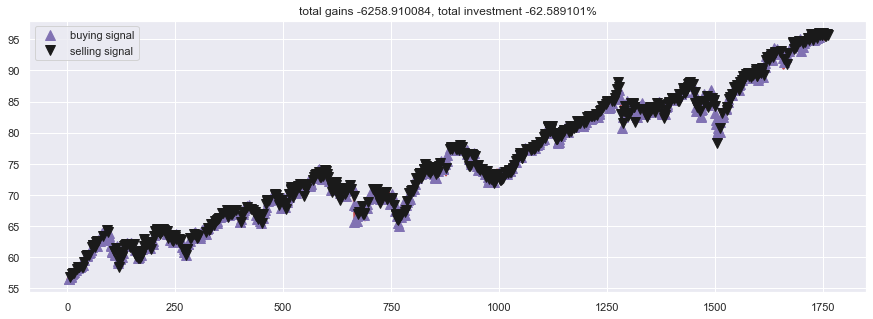

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()